In [1]:
# Load the libraries
import pandas as pd
import os
import re
import seaborn as sn
import pandas as pd
import collections
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
case_list = ['nom','voc','acc','inst','dat','abl','g','loc']

In [2]:
# Function to clean morphological tags by removing unnecessary information
def clean_ma(ma):
    ma = re.sub("([\(\[]).*?([\)\]])", "\g<1>\g<2>", ma).replace('[] ','').strip(' []').replace(' ac','').replace(' ps','').replace('sgpl','sg').replace('sgdu','sg')
    ma = ma.replace('i.','inst.').replace('.','').replace(' ','')
    return ma

# Function for extracting the case information from the morph tag
def get_case(ma):
    indeclinable = ['ind','prep','interj','prep','conj','part']
    case_list = ['nom','voc','acc','i','inst','dat','abl','g','loc']
    gender_list = ['n','f','m','*']
    person_list = ['1','2','3']
    no_list = ['du','sg','pl']
    pops = [' ac',' ps']
    ma=ma.replace('sgpl','sg').replace('sgdu','sg')
    temp = re.sub("([\(\[]).*?([\)\]])", "\g<1>\g<2>", ma).replace('[] ','').strip(' []')
    temp = temp.split('.')
    if temp[-1] == '':
        temp.pop(-1)
    # Remove active passive
    case=''
    no=''
    person=''
    gender=''
    tense=''
    coarse=''
    for a,b in enumerate(temp):
        if b in pops:
            temp.pop(a)
    # Get gender
    for a,b in enumerate(temp):
        if b.strip() in gender_list:
            gender = b.strip()
            temp.pop(a)
    # Get case
    for a,b in enumerate(temp):
        if b.strip() in case_list:
            case = b.strip()
            temp.pop(a)
    if case!= '':
        coarse ='Noun'
    # Get person
    for a,b in enumerate(temp):
        if b.strip() in person_list:
            person = b.strip()
            temp.pop(a)
    # Get no
    for a,b in enumerate(temp):
        if b.strip() in no_list:
            no = b.strip()
            temp.pop(a)
    # Get Tense
    for b in temp:
        tense=tense+ ' '+b.strip()
    tense=tense.strip()

    if tense == 'adv':
        coarse = 'adv'
    for ind in indeclinable:
        if tense == ind:
            coarse = 'Ind'
    if tense == 'abs' or tense == 'ca abs':
        coarse = 'IV'
    if tense!='' and coarse=='':
        if person !='' or no!='':
            coarse= 'FV'
        else:
            coarse = 'IV'
    if case == 'i':
        return 'inst'

    if case !='':
        return case
    else:
        return coarse

### Impossible modifier- Head pairs
Noun-noun relationship is only possible if the modifier in genitive case or modifier and head have the same morphological tag (Visheshana). Otherwise relationships are not possible.

In [6]:
f = open('files/data/ud_pos_ner_dp_train_san','r')
lines = f.readlines()
Noun_noun_pair = dict()
f.close()
w = open('files/analysis/Noun_noun_corner_cases_train_data.txt','w')
frame = []
ct = 0
modifiers = list()
heads = list()
temp = set()
for line in lines:
    if line == '\n':
        data = pd.DataFrame(frame)

        for i in range(len(data)):
            m = get_case(data.iloc[i,2])
            h = get_case(data.iloc[int(float(data.iloc[i,-2]))-1,2])
            if m in case_list and h in case_list:
                if m == h or m ==  'g':
                    w.write('\t'.join(list(data.iloc[i,:]))+'\t'+'---\n')
                else:
                    w.write('\t'.join(list(data.iloc[i,:]))+'\t'+m+'-'+h+'\n')
                    if m+'-'+h not in  Noun_noun_pair.keys():
                        Noun_noun_pair[m+'-'+h] = list()
                        Noun_noun_pair[m+'-'+h].append(data.iloc[i,-1])
                    else:
                        Noun_noun_pair[m+'-'+h].append(data.iloc[i,-1])
#                     if data.iloc[i,-1] == 'viseranam':
                    modifiers.append(m)
                    heads.append(h)   
            else:
                w.write('\t'.join(list(data.iloc[i,:]))+'\t'+'---\n')
        w.write('\n')
        frame = []
        continue
    line = line.split('\t')
    line[-1] = line[-1].replace('\n','')
    frame.append(line)
w.close()


### Heatmap for Noun-noun pairs

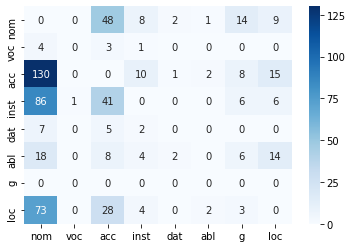

In [7]:
array = confusion_matrix(modifiers, heads, labels=case_list)
df_cm = pd.DataFrame(array, index = case_list, columns = case_list)
plt.figure(figsize = (6,4))
sn.heatmap(df_cm, annot=True, cmap="Blues",  fmt='g')

### What all relations occur for the noun-noun pair

In [8]:
a = Noun_noun_pair['nom-g']
counter=collections.Counter(a)
print(counter)

Counter({'viseranam': 8, 'karwa': 3, 'sambanxah': 2, 'bavalakranasapwami_samanakalah': 1})


### Investigate these noun-noun cases
You can access them [here](https://www.github.com/)